In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('paper')

In [327]:
import numpy as np
import scipy.constants as sc
from scipy.special import erf
from astropy.convolution import convolve, Gaussian2DKernel

class simple_disk:
    """
    Simple disk structure to explore analytic kinematic features.
    
    Args:
        inc (float): Inclination of the source in [degrees].
        PA (float): Position angle of the source in [degrees].
        x0 (Optional[float]): Source center offset along x-axis in [arcsec].
        y0 (Optional[float]): Source center offset along y-axis in [arcsec].
        z0 (Optional[float]): Aspect ratio at 1" for the emission surface.
            To get the far side of the disk, make this number negative.
        psi (Optional[float]): Flaring angle for the emission surface.
        z1 (Optional[float]): Aspect ratio correction term at 1" for the
            emission surface. Should be opposite sign to ``z0``.
        phi (Optional[float]): Flaring angle correction term for the
            emission surface.
        dist (Optional[float]): Distance to the source in [pc].
        mstar (Optional[float]): Mass of the central star in [Msun].
        FOV (Optional[float]): Field of view of the model in [arcsec].
        Tb0 (Optional[float]): Brightness temperature in [K] at 1 arcsec.
        Tbq (Optional[float]): Exponent of the brightness temperature
            radial profile.
        dV0 (Optional[float]): Doppler line width in [m/s] at 1 arcsec.
        dVq (Optional[float]): Exponent of the line width radial profile.
    """
    
    mu = 2.37
    fwhm = 2.*np.sqrt(2.*np.log(2.))
    
    def __init__(self, inc, PA, x0=0.0, y0=0.0, z0=0.0, psi=0.0,
                 z1=0.0, phi=0.0, dist=100.0, mstar=1.0, r_in=1.0,
                 r_out=150., FOV=3.0,
                 Tb0=20.0, Tbq=-0.5, dV0=None, dVq=None):        
        
        # Define the coordinate axes in [arcsec].
        
        self.xaxis = np.linspace(-FOV/2.0, FOV/2.0, 100)[::-1]
        self.yaxis = np.linspace(-FOV/2.0, FOV/2.0, 100)
        self.cell = abs(np.diff(self.xaxis)).mean()
        
        # Calculate the projected pixel coordinates in [au].

        self.dist = dist
        self.inc = inc
        self.PA = PA
        coords = self.disk_coords(x0=x0, y0=y0, inc=inc, PA=PA, z0=z0,
                                  psi=psi, z1=z1, phi=phi)
        self.rvals = coords[0] * self.dist
        self.tvals = coords[1]
        self.zvals = coords[2] * self.dist
        self.xvals = self.rvals * np.cos(self.tvals)
        self.yvals = self.rvals * np.sin(self.tvals)
        
        # Calculate the background velocity field in [m/s].
        # Note that we don't have a systemic velocity.
        
        self.mstar = mstar
        
        # Use a temperature profile to describe the brightness.
        self.set_brightness(Tb0, Tbq)
        self.Tb = np.where(self.rvals >= r_in, self.Tb, 0.0)
        self.Tb = np.where(self.rvals <= r_out, self.Tb, 0.0)
        if dV0 is None:
            dV0 = (2. * sc.k * Tb0 / self.mu / sc.m_p)**0.5
        if dVq is None:
            dVq = 0.5 * Tbq
        self.set_linewidth(dV0, dVq)
        
    @property
    def v_kep(self):
        """
        Calculate the Keplerian velocity field, including vertical shear.
        """
        vkep2 = sc.G * self.mstar * 1.988e30 * self.rvals
        vkep2 /= np.hypot(self.rvals, self.zvals)**3.0
        vkep = np.sqrt(vkep2 / sc.au)
        return vkep * np.cos(self.tvals) * np.sin(np.radians(self.inc))
    
    def azimuthal_flip(self, v0, r0, t0, dr=0.3, dt=0.5, r_split=None, t_split=None):
        """
        Projected azimuthal velocity flip.
        TODO: Check the direction of this (based on sign of inclination).
        """
        r_split = 0.1 * r0 if r_split is None else r_split
        t_split = dt if t_split is None else t_split
        vr_p = v0 * simple_disk.gaussian(self.tvals, (t0 - 0.5 * t_split), dt) 
        vr_p *= simple_disk.gaussian(self.rvals, (r0 - 0.5 * r_split) * self.dist, dr * self.dist)
        vr_n = -v0 * simple_disk.gaussian(self.tvals, (t0 + 0.5 * t_split), dt) 
        vr_n *= simple_disk.gaussian(self.rvals, (r0 + 0.5 * r_split) * self.dist, dr * self.dist)
        return (vr_n + vr_p) * np.cos(self.tvals) * np.sin(np.radians(self.inc))
    
    def radial_flip(self, v0, r0, t0, dr=0.3, dt=0.5, r_split=None, t_split=None):
        """
        Projected radial velocity flip.
        TODO: Check the direction of this (based on sign of inclination).
        """
        r_split = 0.0 if r_split is None else r_split
        t_split = 0.1 if t_split is None else t_split
        vr_p = v0 * simple_disk.gaussian(self.tvals, (t0 - 0.5 * t_split), dt) 
        vr_p *= simple_disk.gaussian(self.rvals, (r0 - 0.5 * r_split) * self.dist, dr * self.dist)
        vr_n = -v0 * simple_disk.gaussian(self.tvals, (t0 + 0.5 * t_split), dt) 
        vr_n *= simple_disk.gaussian(self.rvals, (r0 + 0.5 * r_split) * self.dist, dr * self.dist)
        return (vr_n + vr_p) * np.sin(self.tvals) * np.sin(np.radians(self.inc))

    def vertical_flow(self, v0, r0, t0, dr=0.3, dt=0.5):
        """
        Projected vertical velocity.
        
        Args:
            v0 (float): Velocity in [m/s] of the flow.
            r0 (float): Radial distance in [arcsec] of the flow center.
            t0 (float): Polar angle in [radians] of the flow center.
            dr (float): Radiual width of the flow in [radians].
            dt (float): Polar width of the flow in [radians].
        """
        v0 *= simple_disk.gaussian(self.rvals, r0 * self.dist, dr * self.dist)
        v0 *= simple_disk.gaussian(self.tvals, t0, dt)
        return v0 * np.cos(np.radians(self.inc))

    def disk_coords(self, x0=0.0, y0=0.0, inc=0.0, PA=0.0, z0=0.0, psi=0.0,
                    z1=0.0, phi=0.0, frame='cylindrical'):
        r"""
        Get the disk coordinates given certain geometrical parameters and an
        emission surface. The emission surface is parameterized as a powerlaw
        profile:

        .. math::

            z(r) = z_0 \times \left(\frac{r}{1^{\prime\prime}}\right)^{\psi} +
            z_1 \times \left(\frac{r}{1^{\prime\prime}}\right)^{\varphi}

        Where both ``z0`` and ``z1`` are given in [arcsec]. For a razor thin
        disk, ``z0=0.0``, while for a conical disk, as described in `Rosenfeld
        et al. (2013)`_, ``psi=1.0``. Typically ``z1`` is not needed unless the
        data is exceptionally high SNR and well spatially resolved.

        It is also possible to override this parameterization and directly
        provide a user-defined ``z_func``. This allow for highly complex
        surfaces to be included. If this is provided, the other height
        parameters are ignored.

        .. _Rosenfeld et al. (2013): https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R/

        Args:
            x0 (Optional[float]): Source right ascension offset [arcsec].
            y0 (Optional[float]): Source declination offset [arcsec].
            inc (Optional[float]): Source inclination [deg].
            PA (Optional[float]): Source position angle [deg]. Measured
                between north and the red-shifted semi-major axis in an
                easterly direction.
            z0 (Optional[float]): Aspect ratio at 1" for the emission surface.
                To get the far side of the disk, make this number negative.
            psi (Optional[float]): Flaring angle for the emission surface.
            z1 (Optional[float]): Aspect ratio correction term at 1" for the
                emission surface. Should be opposite sign to ``z0``.
            phi (Optional[float]): Flaring angle correction term for the
                emission surface.
            frame (Optional[str]): Frame of reference for the returned
                coordinates. Either ``'polar'`` or ``'cartesian'``.

        Returns:
            Three coordinate arrays, either the cylindrical coordaintes,
            ``(r, theta, z)`` or cartestian coordinates, ``(x, y, z)``,
            depending on ``frame``.
        """

        # Check the input variables.

        frame = frame.lower()
        if frame not in ['cylindrical', 'cartesian']:
            raise ValueError("frame must be 'cylindrical' or 'cartesian'.")

        # Define the emission surface function. Use the simple double
        # power-law profile.

        def z_func(r):
            z = z0 * np.power(r, psi) + z1 * np.power(r, phi)
            if z0 >= 0.0:
                return np.clip(z, a_min=0.0, a_max=None)
            return np.clip(z, a_min=None, a_max=0.0)

        # Calculate the pixel values.
        r, t, z = self._get_flared_coords(x0, y0, inc, PA, z_func)
        if frame == 'cylindrical':
            return r, t, z
        return r * np.cos(t), r * np.sin(t), z

    
    @staticmethod
    def _rotate_coords(x, y, PA):
        """Rotate (x, y) by PA [deg]."""
        x_rot = y * np.cos(np.radians(PA)) + x * np.sin(np.radians(PA))
        y_rot = x * np.cos(np.radians(PA)) - y * np.sin(np.radians(PA))
        return x_rot, y_rot

    
    @staticmethod
    def _deproject_coords(x, y, inc):
        """Deproject (x, y) by inc [deg]."""
        return x, y / np.cos(np.radians(inc))

    
    def _get_cart_sky_coords(self, x0, y0):
        """Return caresian sky coordinates in [arcsec, arcsec]."""
        return np.meshgrid(self.xaxis - x0, self.yaxis - y0)

    
    def _get_polar_sky_coords(self, x0, y0):
        """Return polar sky coordinates in [arcsec, radians]."""
        x_sky, y_sky = self._get_cart_sky_coords(x0, y0)
        return np.hypot(y_sky, x_sky), np.arctan2(x_sky, y_sky)

    
    def _get_midplane_cart_coords(self, x0, y0, inc, PA):
        """Return cartesian coordaintes of midplane in [arcsec, arcsec]."""
        x_sky, y_sky = self._get_cart_sky_coords(x0, y0)
        x_rot, y_rot = simple_disk._rotate_coords(x_sky, y_sky, PA)
        return simple_disk._deproject_coords(x_rot, y_rot, inc)

    
    def _get_midplane_polar_coords(self, x0, y0, inc, PA):
        """Return the polar coordinates of midplane in [arcsec, radians]."""
        x_mid, y_mid = self._get_midplane_cart_coords(x0, y0, inc, PA)
        return np.hypot(y_mid, x_mid), np.arctan2(y_mid, x_mid)

    
    def _get_flared_coords(self, x0, y0, inc, PA, z_func):
        """Return cylindrical coordinates of surface in [arcsec, radians]."""
        x_mid, y_mid = self._get_midplane_cart_coords(x0, y0, inc, PA)
        r_tmp, t_tmp = np.hypot(x_mid, y_mid), np.arctan2(y_mid, x_mid)
        for _ in range(10):
            y_tmp = y_mid + z_func(r_tmp) * np.tan(np.radians(inc))
            r_tmp = np.hypot(y_tmp, x_mid)
            t_tmp = np.arctan2(y_tmp, x_mid)
        return r_tmp, t_tmp, z_func(r_tmp)
    
    def set_linewidth(self, dV0, dVq):
        """Set the radial linewidth profile in [m/s]."""
        self.dV = simple_disk.powerlaw(self.rvals / 100., dV0, dVq)
        
    def set_brightness(self, Tb0, Tbq):
        """Set the radial brightness temperature profile in [K]."""
        self.Tb = simple_disk.powerlaw(self.rvals / 100., Tb0, Tbq)
        
    def get_cube(self, v0, velax, bmaj=None, bmin=None, bpa=0.0, rms=0.0):
        """
        Return the pseudo-cube with the given velocity axis.
        
        Args:
            v0 (array): 2D array of line centers in [m/s].
            velax (array): 1D array of channel centres in [m/s].
            bmaj (Optional[float]): Beam major axis in [arcsec].
            bmin (Optional[float]): Beam minor axis in [arcsec].
            bpa (Optional[float]): Beam position angle in [degrees].
            rms (Optional[float]): RMS of the noise to add in [K].
        """
        # define the velocity axis
        vchan = abs(np.diff(velax)).mean()
        vbins = np.linspace(velax[0] - 0.5 * vchan,
                            velax[-1] + 0.5 * vchan,
                            velax.size + 1)
        
        # make the image cube
        cube = np.array([self.get_channel(v0, vbins[i], vbins[i+1])
                         for i in range(velax.size)])
        assert cube.shape[0] == velax.size, "not all channels created"
        
        # make the beam kernel
        beam = self._get_beam(bmaj, bmin, bpa) if bmaj is not None else None
        if beam is not None:
            cube = simple_disk._convolve_cube(cube, beam)
        
        # make the noise
        if rms > 0.0:
            noise = np.random.randn(cube.size).reshape(cube.shape)
            if beam is not None:
                noise = simple_disk._convolve_cube(noise, beam)
            noise *= rms / np.std(noise)
        else:
            noise = np.zeros(cube.shape)
        
        # combine
        return cube + noise
    
    @staticmethod
    def _convolve_cube(cube, beam):
        """Convolve the cube."""
        return np.array([convolve(c, beam, boundary='wrap') for c in cube])
    
    def _get_beam(self, bmaj, bmin=None, bpa=0.0):
        """Make a 2D Gaussian kernel for convolution."""
        bmin = bmaj if bmin is None else bmin
        bmaj /= self.cell * self.fwhm
        bmin /= self.cell * self.fwhm
        return Gaussian2DKernel(bmin, bmaj, np.radians(bpa))
    
    def get_channel(self, v0, v_min=None, v_max=None):
        """Calculate the channel emission in [K] for the given ``v0`` map."""
        v_max = np.median(self.dV) if v_max is None else v_max
        v_min = -v_max if v_min is None else v_min
        assert v_max > v_min, "v_max must be larger than v_min"
        flux = self.Tb * np.pi**0.5 * self.dV / 2.0 / (v_max - v_min)
        flux *= erf((v_max - v0) / self.dV) - erf((v_min - v0) / self.dV)
        return flux
        
    def plot_linewidth(self, fig=None):
        """Plot the linewidth profile."""
        if fig is None:
            fig, ax = plt.subplots()
        else:
            ax = fig.axes[0]
        x = self.rvals.flatten()
        y = self.dV.flatten()
        idxs = np.argsort(x)
        ax.plot(x[idxs], y[idxs])
        ax.set_xlabel('Radius [arcsec]')
        ax.set_ylabel('Linewidth [m/s]')
        return fig
    
    def plot_brightness(self, fig=None):
        """Plot the brightness temperature profile."""
        if fig is None:
            fig, ax = plt.subplots()
        else:
            ax = fig.axes[0]
        x = self.rvals.flatten()
        y = self.Tb.flatten()
        idxs = np.argsort(x)
        ax.plot(x[idxs], y[idxs])
        ax.set_xlabel('Radius [arcsec]')
        ax.set_ylabel('Brightness Temperature [K]')
        return fig
    
    @property
    def extent(self):
        return [self.xaxis[0], self.xaxis[-1], self.yaxis[0], self.yaxis[-1]]
    
    @staticmethod
    def gaussian(x, x0, dx, A=1.0):
        return A * np.exp(-((x-x0)/dx)**2)
    
    @staticmethod
    def powerlaw(x, x0, q):
        return x0 * np.power(x, q)
        

In [356]:
test = simple_disk(inc=-47.3, PA=312.0, z0=0.3, psi=1.25, FOV=5.0, dV0=120.)
#test = simple_disk(inc=47.3, PA=90.0, Tb0=10.0, FOV=5.0)

In [357]:
v0 = test.v_kep

velax = np.linspace(-1.0e3, 1.0e3, 21)

fiducial_cube = test.get_cube(v0, velax)

v0 += test.radial_flip(v0=500., r0=1.5, t0=-0.5)

perturbed_cube = test.get_cube(v0, velax, rms=0.2)

In [358]:
convolved_cube = test.get_cube(v0, velax, bmaj=0.3, bpa=30.0, rms=0.2)

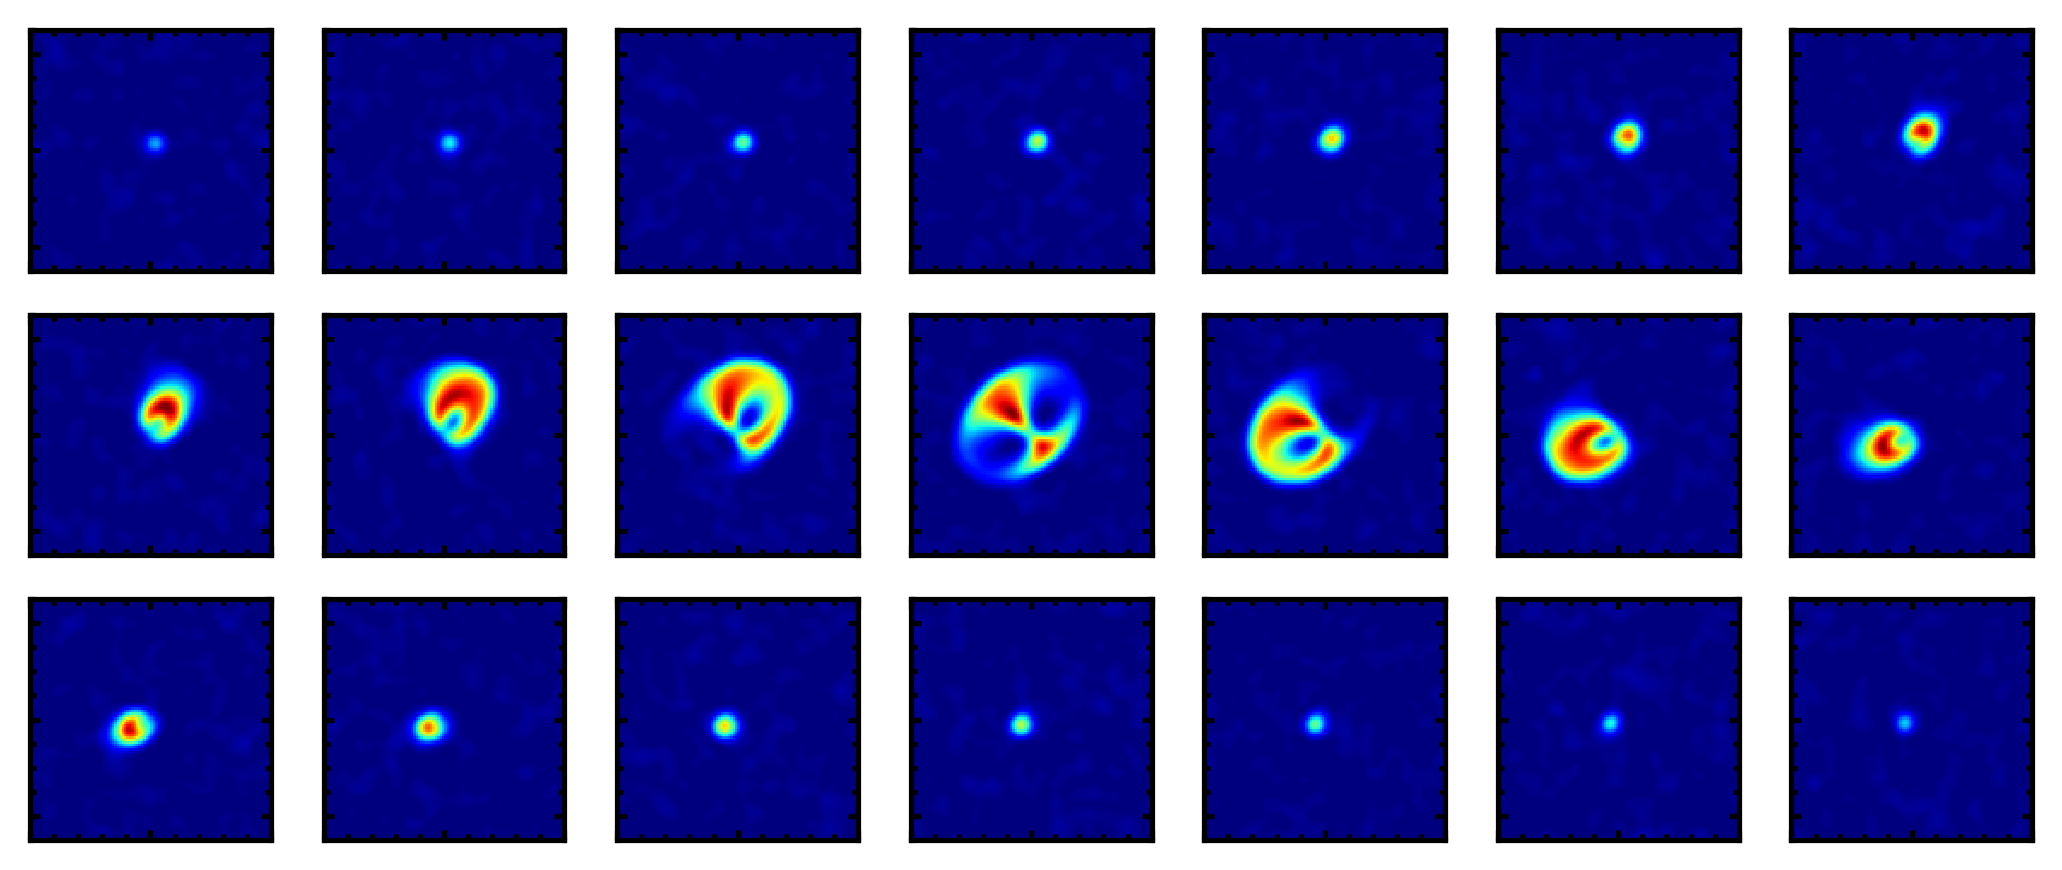

In [361]:
fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(7, 3))
for a, ax in enumerate(axs.flatten()):
    im = ax.imshow(convolved_cube[a], origin='lower', extent=test.extent, cmap='jet', vmax=20., vmin=0.)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()